# CNN model

In [1]:
# Dependencies
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import copy
import sys
import os
import sklearn.metrics as metrics
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from torchinfo import summary
import parameters
import random
from data_formatting import split_sequence_overlap, split_sequence_nooverlap, split_sequence, split_train_test, normalize_data, set_targets
parameters.initialize_parameters()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Architecture

In [73]:
class CNN(nn.Module):
    def __init__(self, input_dim, seq_dim, dropout_rate=0.7):
        super(CNN, self).__init__()
        
        # Define the architecture with layers based on the input arguments
        self.conv1 = nn.Conv1d(seq_dim, 16, 6)
        self.conv2 = nn.Conv1d(16, 64, 3)
        self.conv3 = nn.Conv1d(64, 32 , 3)
        self.relu = nn.ReLU()

        
        self.dropout1 = nn.Dropout(p=dropout_rate)

        # Fully connected layer
        self.fc_input_size = 32 * ( input_dim - 6 - 3 - 3 + 3) 
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2) 

    def forward(self, x):
        # Forward pass
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.dropout1(x)
        x = self.relu(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

## Functions

In [74]:
def validation_accuracy(model, val_loader, nclasses, device, input_dim, error, loss, epoch, test_subj, xv, loss_list, val_loss_list, epoch_list, accuracy_list):
    all_val_predicted = []
    all_val_labels = []
    all_val_outputs = np.empty((0, nclasses), dtype='float')
    correct = 0
    total = 0

    # Iterate through validation dataset
    model.eval()
    with torch.no_grad():
        for features, labels in val_loader:
            features = Variable(features.view(-1, parameters.seq_dim, input_dim)).to(device)
            labels = Variable(labels).to(device)

            # Forward propagation
            outputs = model(features)
            val_loss = error(outputs, labels)

            # Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            predicted = predicted.to('cpu')

            # Total number of labels
            total += labels.size(0)
            correct += (predicted == labels.cpu()).sum()
            all_val_predicted.extend(list(predicted.detach().numpy()))
            all_val_labels.extend(list(labels.cpu().detach().numpy()))
            all_val_outputs = np.concatenate((all_val_outputs, outputs.data.to('cpu').reshape(-1, nclasses)))

    accuracy = correct / float(total)

    # store loss and iteration
    loss_list.append(loss.data)
    val_loss_list.append(val_loss.data)
    epoch_list.append(epoch)
    accuracy_list.append(accuracy)
    print('Subject: {}/{}  Epoch: {:>3}  Loss: {:.6}/{:.6}  Validation accuracy: {:.2f}'.format(test_subj, xv, epoch, loss, val_loss, accuracy))
    return accuracy
    
def cross_accuracy(model, test_loader, avg_test_acc, test_acc_list, test_accuracies, nclasses, device, error_cpu, input_dim, features_test, targets_test, error, xv, test_subj):
    
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    all_outputs = np.empty((0, nclasses), dtype='float')

    # Iterate through test dataset
    model.eval()
    with torch.no_grad():
        if parameters.test_with_subsequences:
            for features, labels in test_loader:
                features = Variable(features.view(-1, parameters.test_seq_dim, input_dim)).to(device)
                labels = Variable(labels).to('cpu')

                # Forward propagation
                outputs = model(features)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                predicted = predicted.to('cpu')

                # Total number of labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predicted.extend(list(predicted.detach().numpy()))
                all_labels.extend(list(labels.detach().numpy()))
                all_outputs = np.concatenate((all_outputs, outputs.data.to('cpu').reshape(-1, nclasses)))

        
        else:
            count=0
            for features in features_test:
                features = torch.tensor(features)
                features = torch.unsqueeze(features, 0).to(device)
                labels = torch.unsqueeze(torch.tensor(targets_test[count]), 0)
                features = Variable(features.view(-1, parameters.test_seq_dim, input_dim)).to(device)

                # Forward propagation
                outputs = model(features)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                predicted = predicted.to('cpu')

                # Total number of labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                count += 1

        accuracy = correct / float(total)

        print(f"Test accuracy for run {test_subj}/{xv}: {accuracy}")

    avg_test_acc += accuracy
    test_acc_list.append(accuracy)


def train_model(list_labels, list_targets, epochs, learning_rate, weight_decay, device, num_validation_subjects, train_df):
    
    target_1 = list_targets[0]
    target_2 = list_targets[1]

    print(f"Training model for {target_1} and {target_2}...")
    # Select only the classes we want to predict
    train_df, nclasses, targets_numpy = set_targets(train_df, list_targets, list_labels)

    # Convert the subject names (strings) into numbers
    subjects = pd.factorize(train_df['Subject'])[0]

    # Normalise the features
    features_numpy = normalize_data(train_df, False) #parameters.normalise_individual_subjects
    input_dim = features_numpy.shape[1]
    #print(f"Number of features: {input_dim}")

    del train_df
    
    # Variable we will use throughout the training and testing
    test_accuracies = []

    # Validation accuracy
    loss_list = []
    val_loss_list = []
    epoch_list = []
    accuracy_list = []

    # Get distinct subjects
    subj = np.unique(subjects)

    # Loop over all subjects
    for test_subj in subj:
        avg_test_acc = 0
        test_acc_list = []
        best_accuracy = 0
        file_name = f'../model_cnn/best_model_checkpoint_{target_1}_{target_2}_{test_subj}.pth'

        # Cross validation
        for xv in range(parameters.cross_validation_passes):

            # Set up the train, validation and test sets
            test_idx = np.array([test_subj])

            # Take out test subject from trainval (Crooss validation)
            trainval_idx = np.delete(subj, np.where(subj==test_subj))
            val_idx = trainval_idx[random.sample(range(len(trainval_idx)), num_validation_subjects)]
            val_idx = val_idx%len(subj)

            # Remove test & validation subjects from trainval
            train_idx = np.setxor1d(subj, test_idx)
            train_idx = np.setxor1d(train_idx, val_idx)

            #print("Generating train/val/test split...")
            features_train, targets_train, features_val, targets_val, features_test, targets_test = split_train_test(targets_numpy, features_numpy, subjects, train_idx, val_idx, test_idx)

            #print("Generating sequences...")
            features_train, targets_train = split_sequence_overlap(features_train, targets_train, parameters.seq_dim, parameters.overlap_size)
            features_val, targets_val = split_sequence_overlap(features_val, targets_val, parameters.seq_dim, parameters.overlap_size)
            
            # Overlap or no
            if parameters.test_with_subsequences:
                features_test, targets_test = split_sequence_overlap(features_test, targets_test, parameters.test_seq_dim, parameters.test_overlap_size)
            else:
                features_test, targets_test = split_sequence_nooverlap(features_test, targets_test, parameters.test_seq_dim, parameters.test_overlap_size)

            #print(f"Number of training examples: {len(targets_train)}")
            #print(f"Number of validation examples: {len(targets_val)}")
            #print(f"Number of test examples: {len(targets_test)}")

            # Create feature and targets tensor for train set. We need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
            featuresTrain = torch.from_numpy(features_train)
            targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)  # data type is long

            featuresVal = torch.from_numpy(features_val)
            targetsVal = torch.from_numpy(targets_val).type(torch.LongTensor)  # data type is long

            # Pytorch train and validation sets
            train = TensorDataset(featuresTrain, targetsTrain)
            val = TensorDataset(featuresVal, targetsVal)
            
            # Data loader
            train_loader = DataLoader(train, batch_size=parameters.batch_size, shuffle=True)
            val_loader = DataLoader(val, batch_size=parameters.batch_size, shuffle=False)

            # Create feature and targets tensor for test set
            if parameters.test_with_subsequences:
                featuresTest = torch.from_numpy(features_test)
                targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)  # data type is long
                test = TensorDataset(featuresTest, targetsTest)
                test_loader = DataLoader(test, batch_size=parameters.batch_size, shuffle=False)
            
            # Model
            model = CNN(input_dim, parameters.seq_dim).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            error = nn.CrossEntropyLoss()
            error_cpu = nn.CrossEntropyLoss().to('cpu')

            # Early Stopping
            
            patience = epochs - 1
            current_patience = 0

            # Train the model
            for epoch in range(epochs):
                model.train()
                running_loss = 0
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    outputs = model(data)
                    loss = error(outputs, target)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

                # Validation accuracy
                accuracy = validation_accuracy(model, val_loader, nclasses, device, input_dim, error, loss, epoch, test_subj, xv, loss_list, val_loss_list, epoch_list, accuracy_list)

                ### Early stopping
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    torch.save(model.state_dict(), file_name)
                    current_patience = 0  # Reset patience counter
                else:
                    current_patience += 1  # No improvement, increase patience counter
                
                if current_patience >= patience:
                    # Early stopping condition met
                    #print(f'Early stopping at epoch {epoch} due to lack of improvement.')
                    break

            # Restore the best model checkpoint
            model.load_state_dict(torch.load(file_name))
        
            # Cross validation accuracy
            cross_accuracy(model, test_loader, avg_test_acc, test_acc_list, test_accuracies, nclasses, device, error_cpu, input_dim, features_test, targets_test, error, xv, test_subj)

        avg_test_acc = np.mean(test_acc_list)
        test_accuracies.append(avg_test_acc)
    
    print("Test accuracies:")
    print(test_accuracies)
    mean_accuracy = np.mean(test_accuracies)
    print(f"Mean accuracy: {mean_accuracy}")
    return mean_accuracy

## Parameters

In [37]:
# Classes we want to predict and binary outputs
list_labels = [0, 1]

# number of subjects used for validation
num_validation_subjects = 1

learning_rate = 0.0001
weight_decay = 10e-4
epochs = 5

print(torch.__version__)
device = torch.device('cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

2.0.1+cu117
Using cpu


## The whole

In [59]:
# 0: SelfStim
# 1: CtrlStim
# 2: SelfRest
# 3: CtrlRest
# 4: SelfSoc
# 5: CtrlSoc

# Get data
csvfile = "../../data/video/All_Subs_Diff_Modules_nofilter_withoutAUc.csv"
train_df = pd.read_csv(csvfile,  delimiter=",")  # 101 features (only AU_r)

# Create folder to save models
if not os.path.exists("../model_cnn/"):
    os.makedirs("../model_cnn/")

results_dict = {}

# train all models
for i in range(6):
    for j in range(i+1, 6):
        list_targets = [i, j]
        accuracy = train_model(list_labels,list_targets, epochs, learning_rate, weight_decay, device, num_validation_subjects, train_df)
        results_dict[tuple(list_targets)] = accuracy

print(results_dict)

The file best_model_checkpoint_0_1.pth has been deleted.
Training model for 0 and 1...
Test accuracy for run 0/0: 0.8077496274217586
Test accuracy for run 0/1: 0.8077496274217586
Test accuracy for run 0/2: 0.8077496274217586
Test accuracy for run 1/0: 0.7308781869688386
Test accuracy for run 1/1: 0.8243626062322946
Test accuracy for run 1/2: 0.8243626062322946
Test accuracy for run 2/0: 0.5896656534954408
Test accuracy for run 2/1: 0.5881458966565349
Test accuracy for run 2/2: 0.5881458966565349
Test accuracy for run 3/0: 0.583743842364532
Test accuracy for run 3/1: 0.5935960591133005
Test accuracy for run 3/2: 0.5935960591133005
Test accuracy for run 4/0: 0.5743073047858942
Test accuracy for run 4/1: 0.5617128463476071
Test accuracy for run 4/2: 0.5617128463476071
Test accuracy for run 5/0: 0.48105436573311366
Test accuracy for run 5/1: 0.48105436573311366
Test accuracy for run 5/2: 0.46293245469522243
Test accuracy for run 6/0: 0.6206896551724138
Test accuracy for run 6/1: 0.62068965

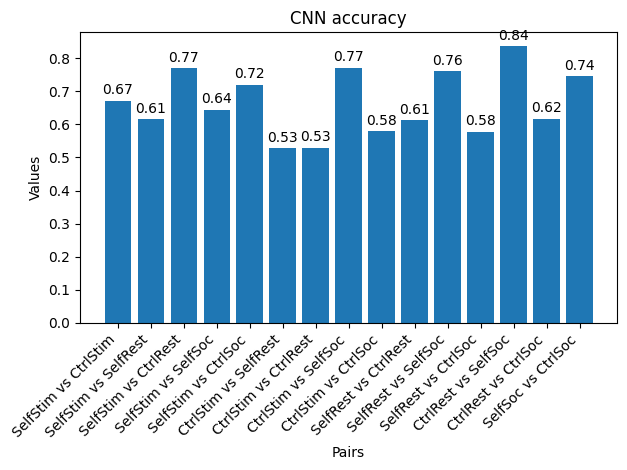

In [65]:
# Mapping between digits and their names
label_mapping = {
    0: 'SelfStim',
    1: 'CtrlStim',
    2: 'SelfRest',
    3: 'CtrlRest',
    4: 'SelfSoc',
    5: 'CtrlSoc'
}

# Extracting data for the plot
pairs = list(results_dict.keys())
values = list(results_dict.values())
x_labels = [f"{label_mapping[pair[0]]} vs {label_mapping[pair[1]]}" for pair in pairs]

# Creating the bar plot
plt.bar(x_labels, values)
plt.xlabel('Pairs')
plt.ylabel('Accuracy')
plt.title('CNN accuracy')

# Displaying values on the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

## Training

In [10]:
list_targets = [1, 2]

In [38]:
# Get data
csvfile = "../../data/video/All_Subs_Diff_Modules_nofilter_withoutAUc.csv"
train_df = pd.read_csv(csvfile,  delimiter=",")  # 101 features (only AU_r)

# Select only the classes we want to predict
train_df, nclasses, targets_numpy = set_targets(train_df, list_targets, list_labels)

# Convert the subject names (strings) into numbers
subjects = pd.factorize(train_df['Subject'])[0]

# Normalise the features
features_numpy = normalize_data(train_df, False) #parameters.normalise_individual_subjects
input_dim = features_numpy.shape[1]
print(f"Number of features: {input_dim}")

del train_df

Number of features: 100


In [76]:
# Variable we will use throughout the training and testing
test_accuracies = []
calibrated_test_accuracies = []
all_outputs = np.empty((0, nclasses), dtype='float')

# Validation accuracy
loss_list = []
val_loss_list = []
epoch_list = []
accuracy_list = []

# Get distinct subjects
subj = np.unique(subjects)

if not os.path.exists("../model_cnn/"):
    os.makedirs("../model_cnn/")


# Loop over all subjects
for test_subj in subj:
    xv_max_val = 0
    avg_test_acc = 0
    val_acc_val_loss_list = []
    test_acc_list = []
    best_accuracy = 0
    file_name = f'../model_cnn/best_model_checkpoint_{list_targets[0]}_{list_targets[1]}_{test_subj}.pth'

    # Cross validation
    for xv in range(parameters.cross_validation_passes):

        # Set up the train, validation and test sets
        test_idx = np.array([test_subj])

        # Take out test subject from trainval (Crooss validation)
        trainval_idx = np.delete(subj, np.where(subj==test_subj))
        val_idx = trainval_idx[random.sample(range(len(trainval_idx)), num_validation_subjects)]
        val_idx = val_idx%len(subj)

        # Remove test & validation subjects from trainval
        train_idx = np.setxor1d(subj, test_idx)
        train_idx = np.setxor1d(train_idx, val_idx)

        #print("Generating train/val/test split...")
        features_train, targets_train, features_val, targets_val, features_test, targets_test = split_train_test(targets_numpy, features_numpy, subjects, train_idx, val_idx, test_idx)

        #print("Generating sequences...")
        features_train, targets_train = split_sequence_overlap(features_train, targets_train, parameters.seq_dim, parameters.overlap_size)
        features_val, targets_val = split_sequence_overlap(features_val, targets_val, parameters.seq_dim, parameters.overlap_size)
        
        # Overlap or no
        if parameters.test_with_subsequences:
            features_test, targets_test = split_sequence_overlap(features_test, targets_test, parameters.test_seq_dim, parameters.test_overlap_size)
        else:
            features_test, targets_test = split_sequence_nooverlap(features_test, targets_test, parameters.test_seq_dim, parameters.test_overlap_size)

        #print(f"Number of training examples: {len(targets_train)}")
        #print(f"Number of validation examples: {len(targets_val)}")
        #print(f"Number of test examples: {len(targets_test)}")

        # Create feature and targets tensor for train set. We need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
        featuresTrain = torch.from_numpy(features_train)
        targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)  # data type is long

        featuresVal = torch.from_numpy(features_val)
        targetsVal = torch.from_numpy(targets_val).type(torch.LongTensor)  # data type is long

        # Pytorch train and validation sets
        train = TensorDataset(featuresTrain, targetsTrain)
        val = TensorDataset(featuresVal, targetsVal)
        
        # Data loader
        train_loader = DataLoader(train, batch_size=parameters.batch_size, shuffle=True)
        val_loader = DataLoader(val, batch_size=parameters.batch_size, shuffle=False)

        # Create feature and targets tensor for test set
        if parameters.test_with_subsequences:
            featuresTest = torch.from_numpy(features_test)
            targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)  # data type is long
            test = TensorDataset(featuresTest, targetsTest)
            test_loader = DataLoader(test, batch_size=parameters.batch_size, shuffle=False)
        
        # Model
        model = CNN(input_dim, parameters.seq_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        error = nn.CrossEntropyLoss()
        error_cpu = nn.CrossEntropyLoss().to('cpu')

        # Early Stopping
        
        patience = epochs - 1
        #patience = 4
        current_patience = 0

        # Train the model
        for epoch in range(epochs):
            model.train()
            running_loss = 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                loss = error(outputs, target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Validation accuracy
            accuracy = validation_accuracy(model, val_loader, nclasses, device, input_dim, error, loss, epoch, test_subj, xv, loss_list, val_loss_list, epoch_list, accuracy_list)

            ### Early stopping
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                torch.save(model.state_dict(), file_name)
                current_patience = 0  # Reset patience counter
            else:
                current_patience += 1  # No improvement, increase patience counter
            
            if current_patience >= patience:
                # Early stopping condition met
                print(f'Early stopping at epoch {epoch} due to lack of improvement.')
                break

        # Restore the best model checkpoint
        model.load_state_dict(torch.load(file_name))
    
        # Cross validation accuracy
        cross_accuracy(model, test_loader, avg_test_acc, test_acc_list, test_accuracies, nclasses, device, error_cpu, input_dim, features_test, targets_test, error, xv, test_subj)

    avg_test_acc = np.mean(test_acc_list)
    test_accuracies.append(avg_test_acc)
  
print("Test accuracies:")
print(test_accuracies)
print(f"Mean accuracy: {np.mean(test_accuracies)}")

Subject: 0/0  Epoch:   0  Loss: 0.688342/0.666002  Validation accuracy: 0.54
Subject: 0/0  Epoch:   1  Loss: 0.631872/0.58294  Validation accuracy: 0.42
Subject: 0/0  Epoch:   2  Loss: 0.267149/0.317667  Validation accuracy: 0.62
Subject: 0/0  Epoch:   3  Loss: 0.422559/0.446509  Validation accuracy: 0.67


KeyboardInterrupt: 

In [19]:
# save the model
PATH = './model.pth'
torch.save(model.state_dict(), PATH)